In [1]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/3rd_experiment/01_lextac_source.wav')

(target_fs, target_l_data) = wavfile.read('./data/3rd_experiment/01_lextac_gain_low.wav')
(target_fs, target_m_data) = wavfile.read('./data/3rd_experiment/01_lextac_gain_mid.wav')
(target_fs, target_h_data) = wavfile.read('./data/3rd_experiment/01_lextac_gain_hi.wav')

In [2]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])['L']

target_l_df = pd.DataFrame(target_l_data, columns=['L', 'R'])['L']
target_m_df = pd.DataFrame(target_m_data, columns=['L', 'R'])['L']
target_h_df = pd.DataFrame(target_h_data, columns=['L', 'R'])['L']

(
    source_df.max(),
    target_l_df.max(), target_m_df.max(), target_h_df.max(),
)

(28259, 27366, 30817, 31643)

In [4]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [5]:
(
    len(source_df),
    len(target_l_df), len(target_m_df), len(target_h_df),
)

(732739, 732739, 732739, 732739)

## Data processing

In [6]:
# N_TRAIN = 44000
# N_TEST = 44000
N_TRAIN = 4*44000
N_TEST = 40000
N_TRAIN, N_TEST

(176000, 40000)

In [7]:
import numpy as np

In [8]:
# Adding knobs features

X_train_raw_l = pd.Series(list(map(lambda x: [x,  0.0], source_df[:N_TRAIN])))
X_train_raw_m = pd.Series(list(map(lambda x: [x,  0.5], source_df[:N_TRAIN])))
X_train_raw_h = pd.Series(list(map(lambda x: [x,  1.0], source_df[:N_TRAIN])))

(
    len(X_train_raw_l), len(X_train_raw_m), len(X_train_raw_h),
)

(176000, 176000, 176000)

In [9]:
X_test_raw_l = pd.Series(list(map(lambda x: [x, 0.0], source_df[N_TRAIN:N_TRAIN + N_TEST])))
X_test_raw_m = pd.Series(list(map(lambda x: [x, 0.5], source_df[N_TRAIN:N_TRAIN + N_TEST])))
X_test_raw_h = pd.Series(list(map(lambda x: [x, 1.0], source_df[N_TRAIN:N_TRAIN + N_TEST])))

len(X_test_raw_l), len(X_test_raw_m), len(X_test_raw_h)

(40000, 40000, 40000)

In [10]:
y_train_raw_l = pd.Series(target_l_df[:N_TRAIN])
y_train_raw_m = pd.Series(target_m_df[:N_TRAIN])
y_train_raw_h = pd.Series(target_h_df[:N_TRAIN])

(
    len(y_train_raw_l), len(y_train_raw_m), len(y_train_raw_h),
)

(176000, 176000, 176000)

In [11]:
y_test_raw_l = pd.Series(target_l_df[:N_TEST])
y_test_raw_m = pd.Series(target_m_df[:N_TEST])
y_test_raw_h = pd.Series(target_h_df[:N_TEST])

len(y_test_raw_l), len(y_test_raw_m), len(y_test_raw_h)

(40000, 40000, 40000)

In [12]:
import IPython.display as ipd
ipd.Audio(y_test_raw_m, rate=44000)

In [13]:
n_features = 2
N_WINDOW_POINTS = 32

In [14]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [15]:
def make_windows(X, y, n_window_points):
    index = 0
    
    res_X = []
    res_y = []
    
    for index in range(0, min(len(X), len(y)) - n_window_points - 1):
        res_X.append(X[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [16]:
def norm_make_windows_and_reshape(X, y, n_samples, n_window_points):
    X_n = np.array(list(map(lambda x: np.array([x[0] / MAX_VALUE] + x[1:]), X)))
    X_n = X_n.astype('float32')
    
    y_s = np.array(list(map(lambda x: np.array(x), y)))
    y_n = normalize(y_s, forced_abs=MAX_VALUE, mean=0.0)
    y_n = y_n.astype('float32')
    
    (X_f, y_f) = make_windows(
        X_n[:(n_samples + n_window_points + 1)],
        y_n[:(n_samples + n_window_points + 1)],
        n_window_points
    )
    
    return (X_f, y_f)

In [17]:
(X_tr_l_f, y_tr_l_f) = norm_make_windows_and_reshape(X_train_raw_l, y_train_raw_l, N_TRAIN, N_WINDOW_POINTS)
(X_tr_m_f, y_tr_m_f) = norm_make_windows_and_reshape(X_train_raw_m, y_train_raw_m, N_TRAIN, N_WINDOW_POINTS)
(X_tr_h_f, y_tr_h_f) = norm_make_windows_and_reshape(X_train_raw_h, y_train_raw_h, N_TRAIN, N_WINDOW_POINTS)

print(len(X_tr_l_f), len(X_tr_m_f), len(X_tr_h_f))

175967 175967 175967


In [18]:
(X_te_l_f, y_te_l_f) = norm_make_windows_and_reshape(X_test_raw_l, y_test_raw_l, N_TEST, N_WINDOW_POINTS)
(X_te_m_f, y_te_m_f) = norm_make_windows_and_reshape(X_test_raw_m, y_test_raw_m, N_TEST, N_WINDOW_POINTS)
(X_te_h_f, y_te_h_f) = norm_make_windows_and_reshape(X_test_raw_h, y_test_raw_h, N_TEST, N_WINDOW_POINTS)

print(len(X_te_l_f), len(y_te_l_f))
print(len(X_te_h_f), len(y_te_h_f))
print(len(X_te_m_f), len(y_te_m_f))

39967 39967
39967 39967
39967 39967


In [19]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Train gain knob data')

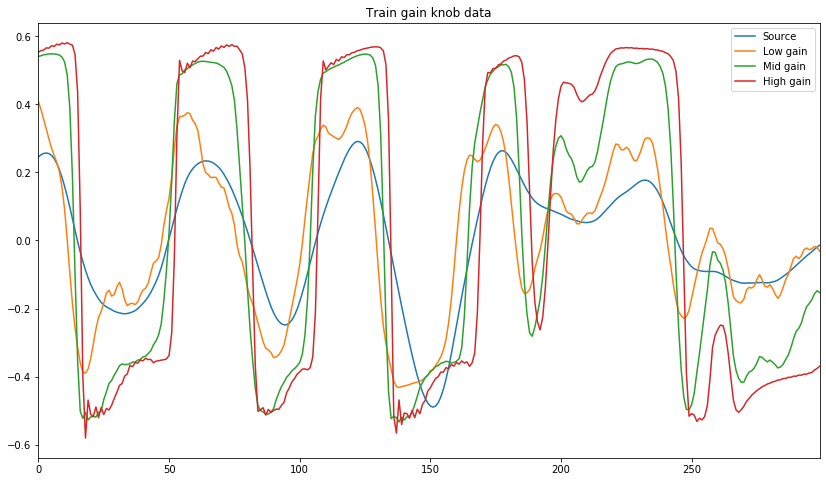

In [20]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(14, 8))

start = 6500
n = start + 300

pd.Series(map(lambda x: x[-1][0], X_tr_l_f[start:n])).plot.line(ax=ax, label='Source')
pd.Series(y_tr_l_f[start:n]).plot.line(ax=ax, label='Low gain')
pd.Series(y_tr_m_f[start:n]).plot.line(ax=ax, label='Mid gain')
pd.Series(y_tr_h_f[start:n]).plot.line(ax=ax, label='High gain')
ax.legend(loc='upper right')
ax.set_title('Train gain knob data')

Text(0.5, 1.0, 'Test gain knob data')

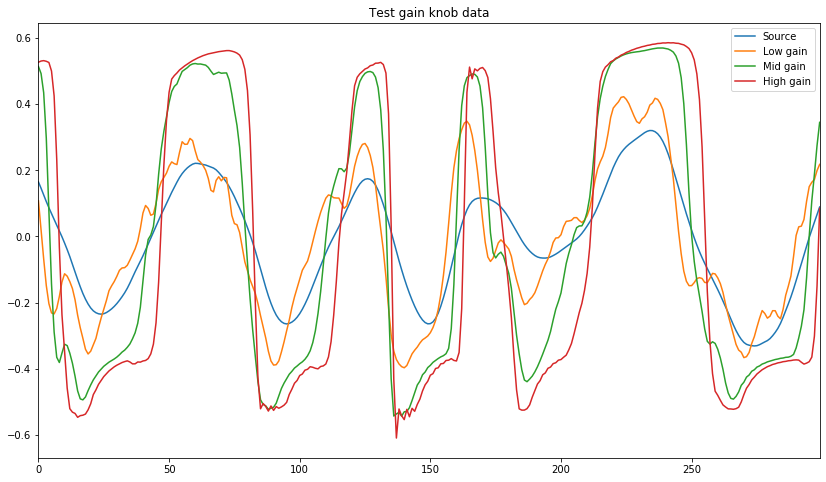

In [21]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(14, 8))

start = 6000
n = start + 300

pd.Series(map(lambda x: x[-1][0], X_tr_l_f[start:n])).plot.line(ax=ax, label='Source')
pd.Series(y_te_l_f[start:n]).plot.line(ax=ax, label='Low gain')
pd.Series(y_te_m_f[start:n]).plot.line(ax=ax, label='Mid gain')
pd.Series(y_te_h_f[start:n]).plot.line(ax=ax, label='High gain')
ax.legend(loc='upper right')
ax.set_title('Test gain knob data')

In [22]:
X_tr_s = np.concatenate([X_tr_l_f, X_tr_m_f, X_tr_h_f])
y_tr_s = np.concatenate([y_tr_l_f, y_tr_m_f, y_tr_h_f])
     
len(X_tr_s), len(y_tr_s), np.min(X_tr_s), np.min(y_tr_s)

(527901, 527901, -0.8663595, -0.7709891)

In [23]:
X_te_s = np.concatenate([X_te_l_f, X_te_m_f, X_te_h_f])
y_te_s = np.concatenate([y_te_l_f, y_te_m_f, y_te_h_f])
     
len(X_te_s), len(y_te_s), np.min(X_te_s), np.min(y_te_s)

(119901, 119901, -0.85314494, -0.7227088)

## Finished data processing!

## Moving on to training NN

In [24]:
import numpy as np

In [25]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, CuDNNLSTM, Reshape, GRU, CuDNNGRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

Using TensorFlow backend.


In [26]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((527901, 32, 2), (527901,), (119901, 32, 2), (119901,))

In [27]:
import math

def predict(model, X_input, batch_size=1, verbose=0):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
#             X_input[:(math.floor(len(X_input) / batch_size) * batch_size)],
            X_input,
            batch_size=batch_size,
            verbose=verbose,
        )
    ).flatten()

In [28]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class PreviewLearning(keras.callbacks.Callback):
    def __init__(self, model, n_start=200, n_end=400, batch_size=1):
        self.model = model
        self.n_start = n_start
        self.n_end = n_end
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
        (fig, ax) = plt.subplots(figsize=(12, 8))
        n_start = self.n_start
        n_end = self.n_end
#         (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[n_start:n_end])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[n_start:n_end])))

        pred = pd.Series(np.zeros(n_end - n_start))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(n_end - n_start))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(n_end-n_start))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        loss = logs['loss']
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        n_start = self.n_start
        n_end = self.n_end
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[n_start:n_end])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[n_start:n_end])))

        pred = pd.Series(predict(model, X_tr_s[n_start:n_end], batch_size=batch_size))
        pred = pred + 0.001

        self.targ_data.set_ydata(targ.values)
        self.pred_data.set_ydata(pred.values)
        
        ax.set_title('NN predictions on first {} samples, epoch {}, loss={:.4f}'.format(n_end-n_start, epoch_n, loss))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [29]:
from keras import backend as K
    
def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
# def create_model(params, recurrent_layer=CuDNNLSTM):
def create_model(params, recurrent_layer=LSTM):
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    gru_1_L = recurrent_layer(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
#         return_sequences=True,
    )(input_L)

#     gru_2_L = recurrent_layer(
#         params['n_units'],
#         input_shape=(N_WINDOW_POINTS, n_features),
#         batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
# #         bias_regularizer=L1L2(l1=0.01, l2=0.01),
# #         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
#         stateful=True,
#         # reset_after=True,
#         # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
# #         activation='tanh',
# #         recurrent_activation='hard_sigmoid',
#         # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
#         kernel_initializer=keras.initializers.glorot_uniform(seed=43),
# #         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
#         recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
#         # kernel_initializer='identity',
#         bias_initializer='zeros',
#     #     return_sequences=True,
#     )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    )(gru_1_L)
#     )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, x_val, y_val, params, verbose_fit=0, preview_n_start=1000, preview_n_end=2000):
    print(params)
    
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.9
        epochs_drop = 40.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    preview_learning = PreviewLearning(
        model,
        n_start=preview_n_start,
        n_end=preview_n_end,
        batch_size=params['batch_size']
    )

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
        batch_size=params['batch_size'],
        shuffle=False,
        epochs=params['epochs'],
        verbose=verbose_fit,
        callbacks=[es_cb, preview_learning, lrate],
#         callbacks=[es_cb, preview_learning],
    )
    
    return (history, model)


def create_and_train_model(X_tr, y_tr, x_val, y_val, params):
    model = create_model(params)

    (history, model) = train_model(
        model,
        X_tr_s,
        y_tr_s,
        X_te_s,
        y_te_s,
#         X_tr_s[:params['n_samples']],
#         y_tr_s[:params['n_samples']],
#         X_te_s[:params['n_samples']],
#         y_te_s[:params['n_samples']],
        params
    )
    
    return (history, model)

  0%|          | 0/9 [00:00<?, ?it/s]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


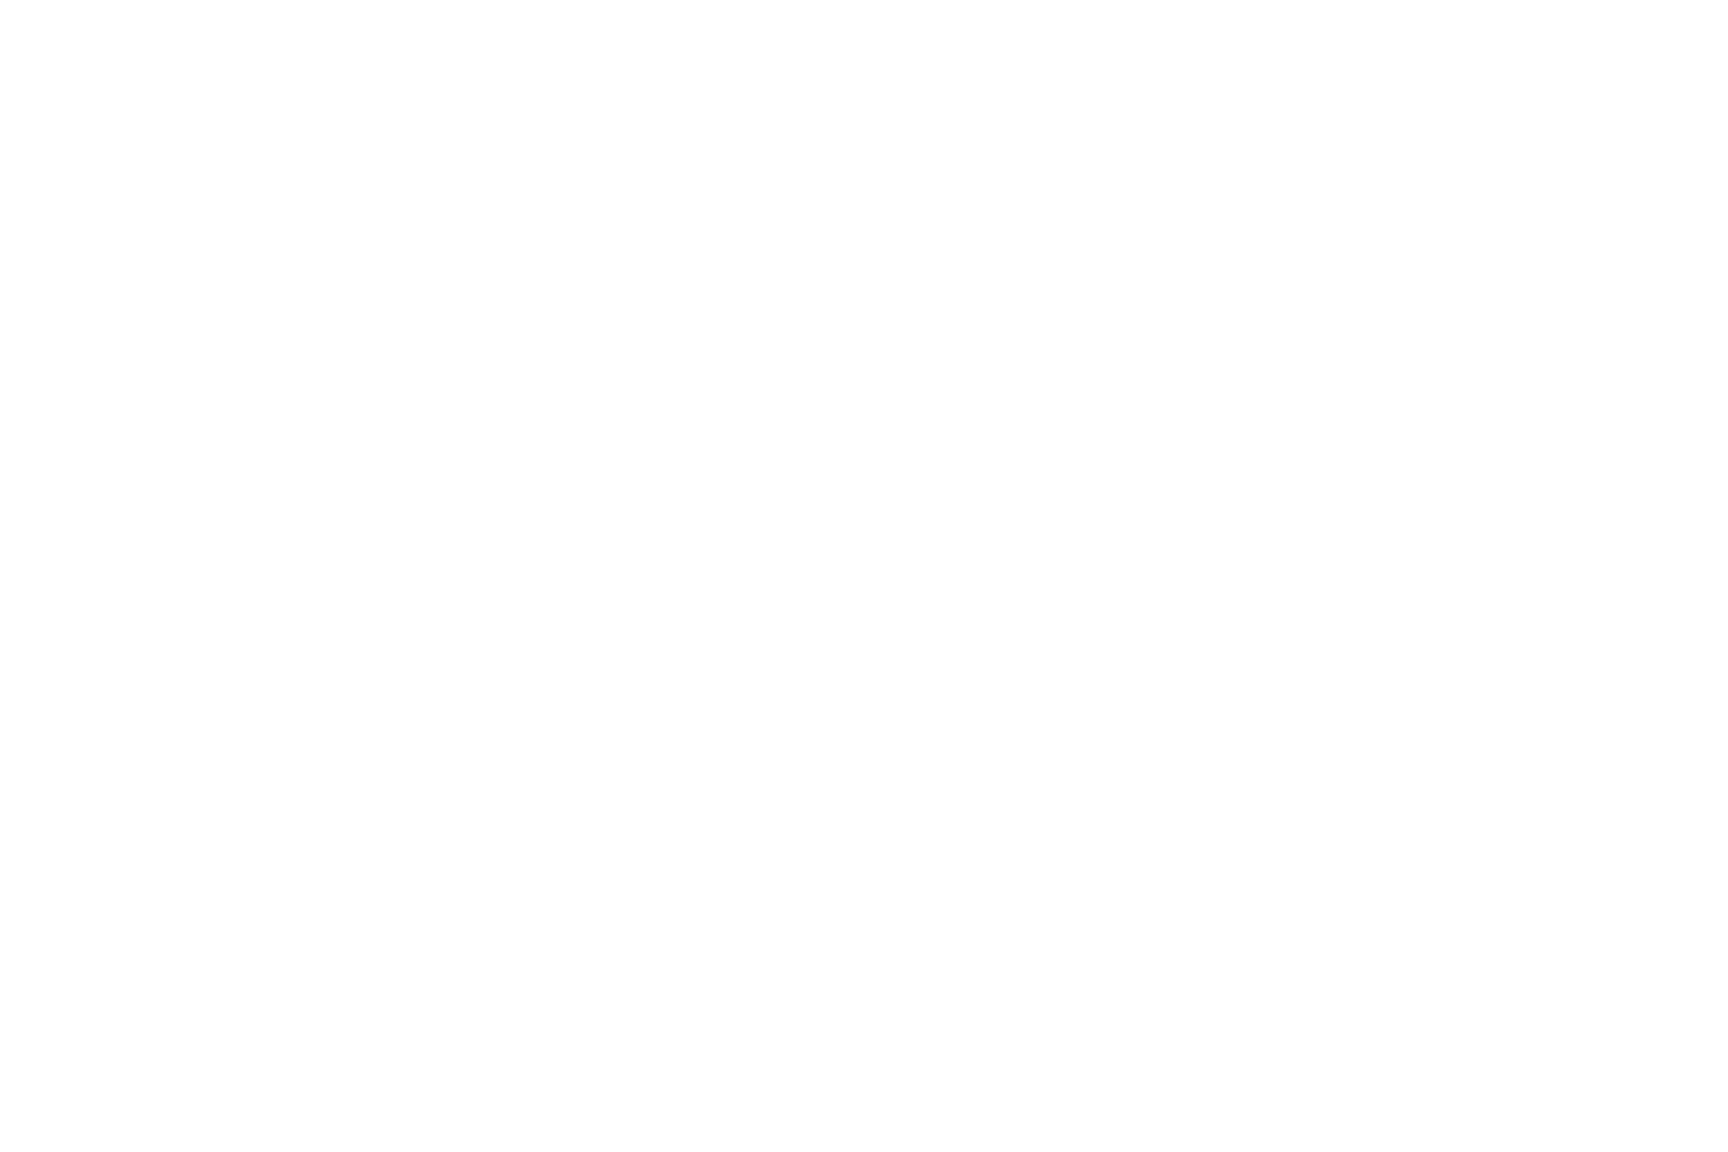

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_49:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/callbacks.py", line 651, in on_epoch_begin
    lr = float(K.get_value(self.model.optimizer.lr))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2407, in get_value
    return x.eval(session=get_session())  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 206, in get_session
    session.run(tf.variables_initializer(uninitialized_vars))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 199, in <listcomp>
    [tf.is_variable_initialized(v) fo

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_42:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/callbacks.py", line 651, in on_epoch_begin
    lr = float(K.get_value(self.model.optimizer.lr))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2407, in get_value
    return x.eval(session=get_session())  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 206, in get_session
    session.run(tf.variables_initializer(uninitialized_vars))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 199, in <listcomp>
    [tf.is_variable_initialized(v) fo

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_35:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/callbacks.py", line 651, in on_epoch_begin
    lr = float(K.get_value(self.model.optimizer.lr))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2407, in get_value
    return x.eval(session=get_session())  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 206, in get_session
    session.run(tf.variables_initializer(uninitialized_vars))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 199, in <listcomp>
    [tf.is_variable_initialized(v) fo

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_28:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/callbacks.py", line 651, in on_epoch_begin
    lr = float(K.get_value(self.model.optimizer.lr))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2407, in get_value
    return x.eval(session=get_session())  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 206, in get_session
    session.run(tf.variables_initializer(uninitialized_vars))  File "/home/naissur/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 199, in <listcomp>
    [tf.is_variable_initialized(v) fo

RuntimeError: Attempted to use a closed Session.

<IPython.core.display.Javascript object>


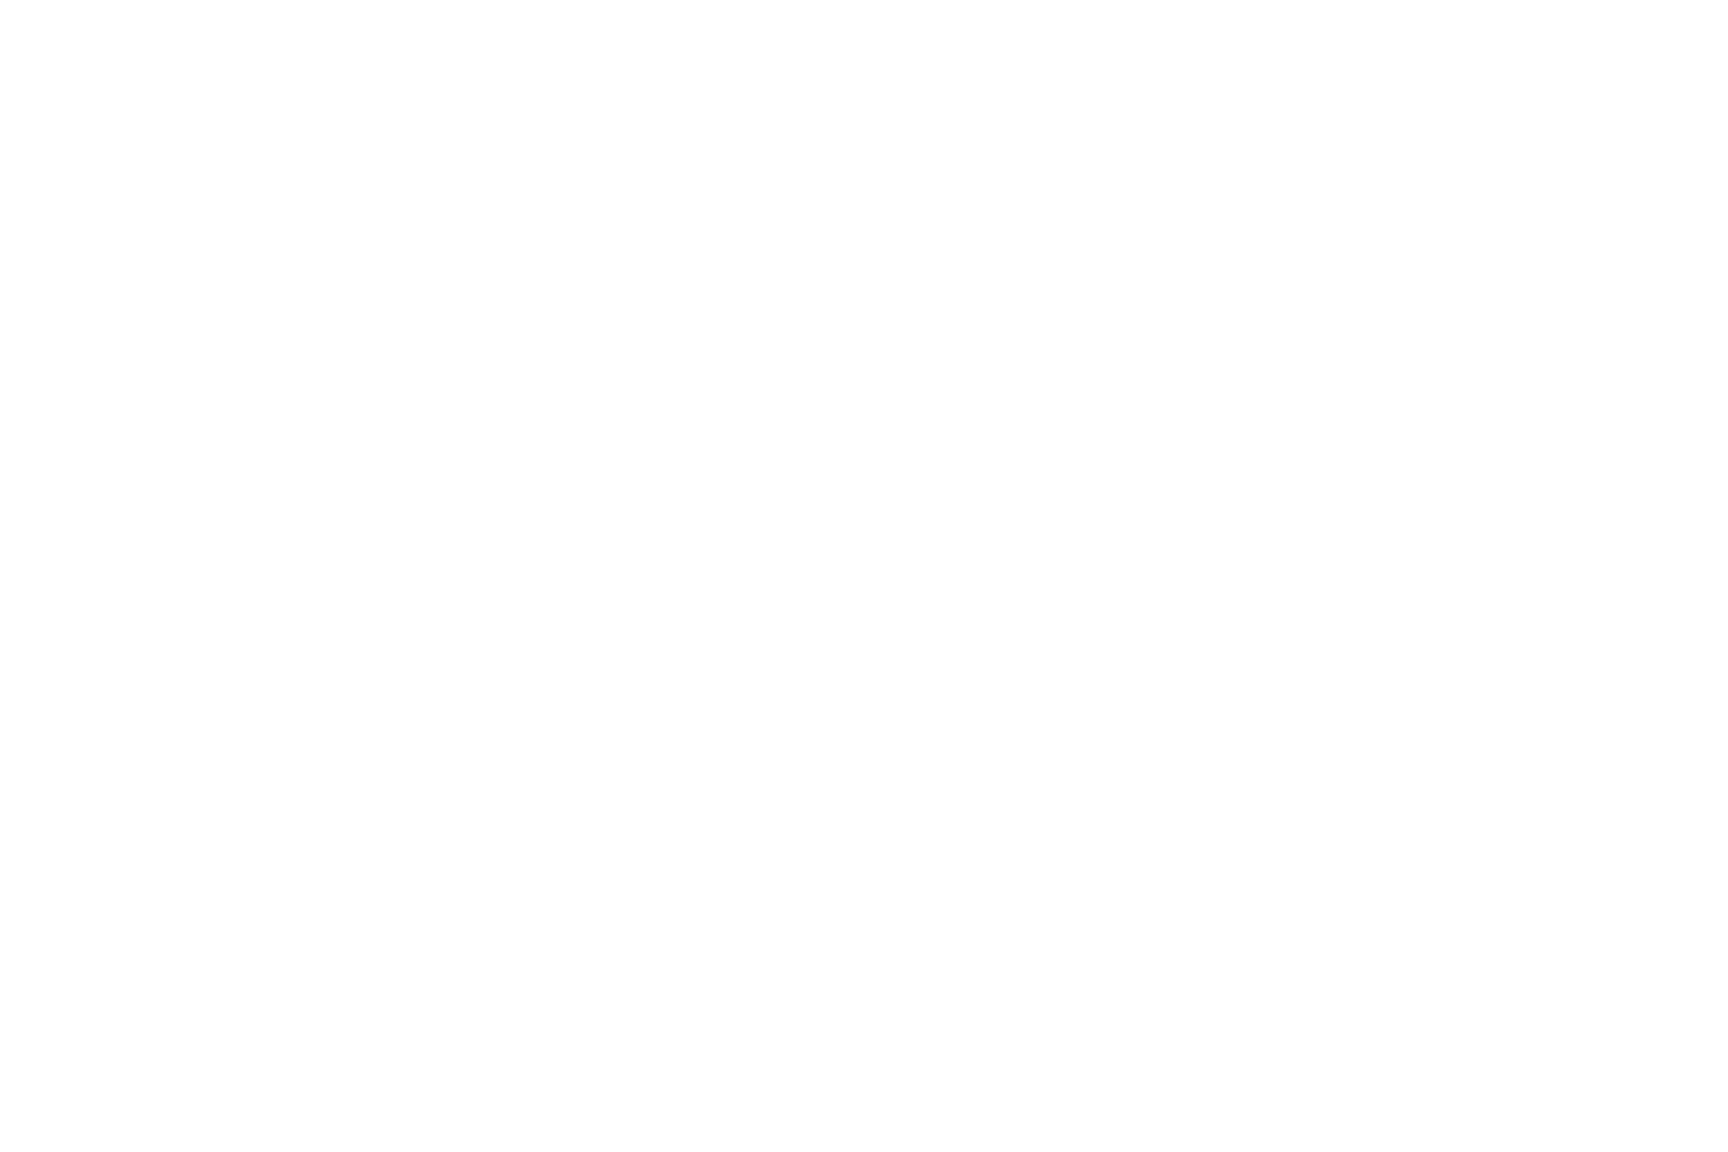

In [61]:
%matplotlib notebook

from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.001, 0.002, 0.004],
     'n_samples': [4700],
     'n_units': [16, 20, 24],
#      'batch_size': [10, 100, 1000],
     'batch_size': [100],
     'epochs': [100],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }

# 'lr': 0.004,
# 'n_samples': 44000 * 3,
# 'n_units': 20,
# 'batch_size': 500,
# 'epochs': 100,
# 'optimizer': keras.optimizers.Adam,
        
# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_and_train_model,
#             grid_downsample=0.5,
            params=p,
            experiment_name='test')

globals().update(locals())

In [ ]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')


In [ ]:
best_params = r.data.loc[7]
best_params

In [ ]:
type(best_params)




{'lr': 0.007, 'n_samples': 527872, 'n_units': 16, 'batch_size': 512, 'epochs': 60, 'optimizer': <class 'keras.optimizers.Adam'>}

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




<IPython.core.display.Javascript object>


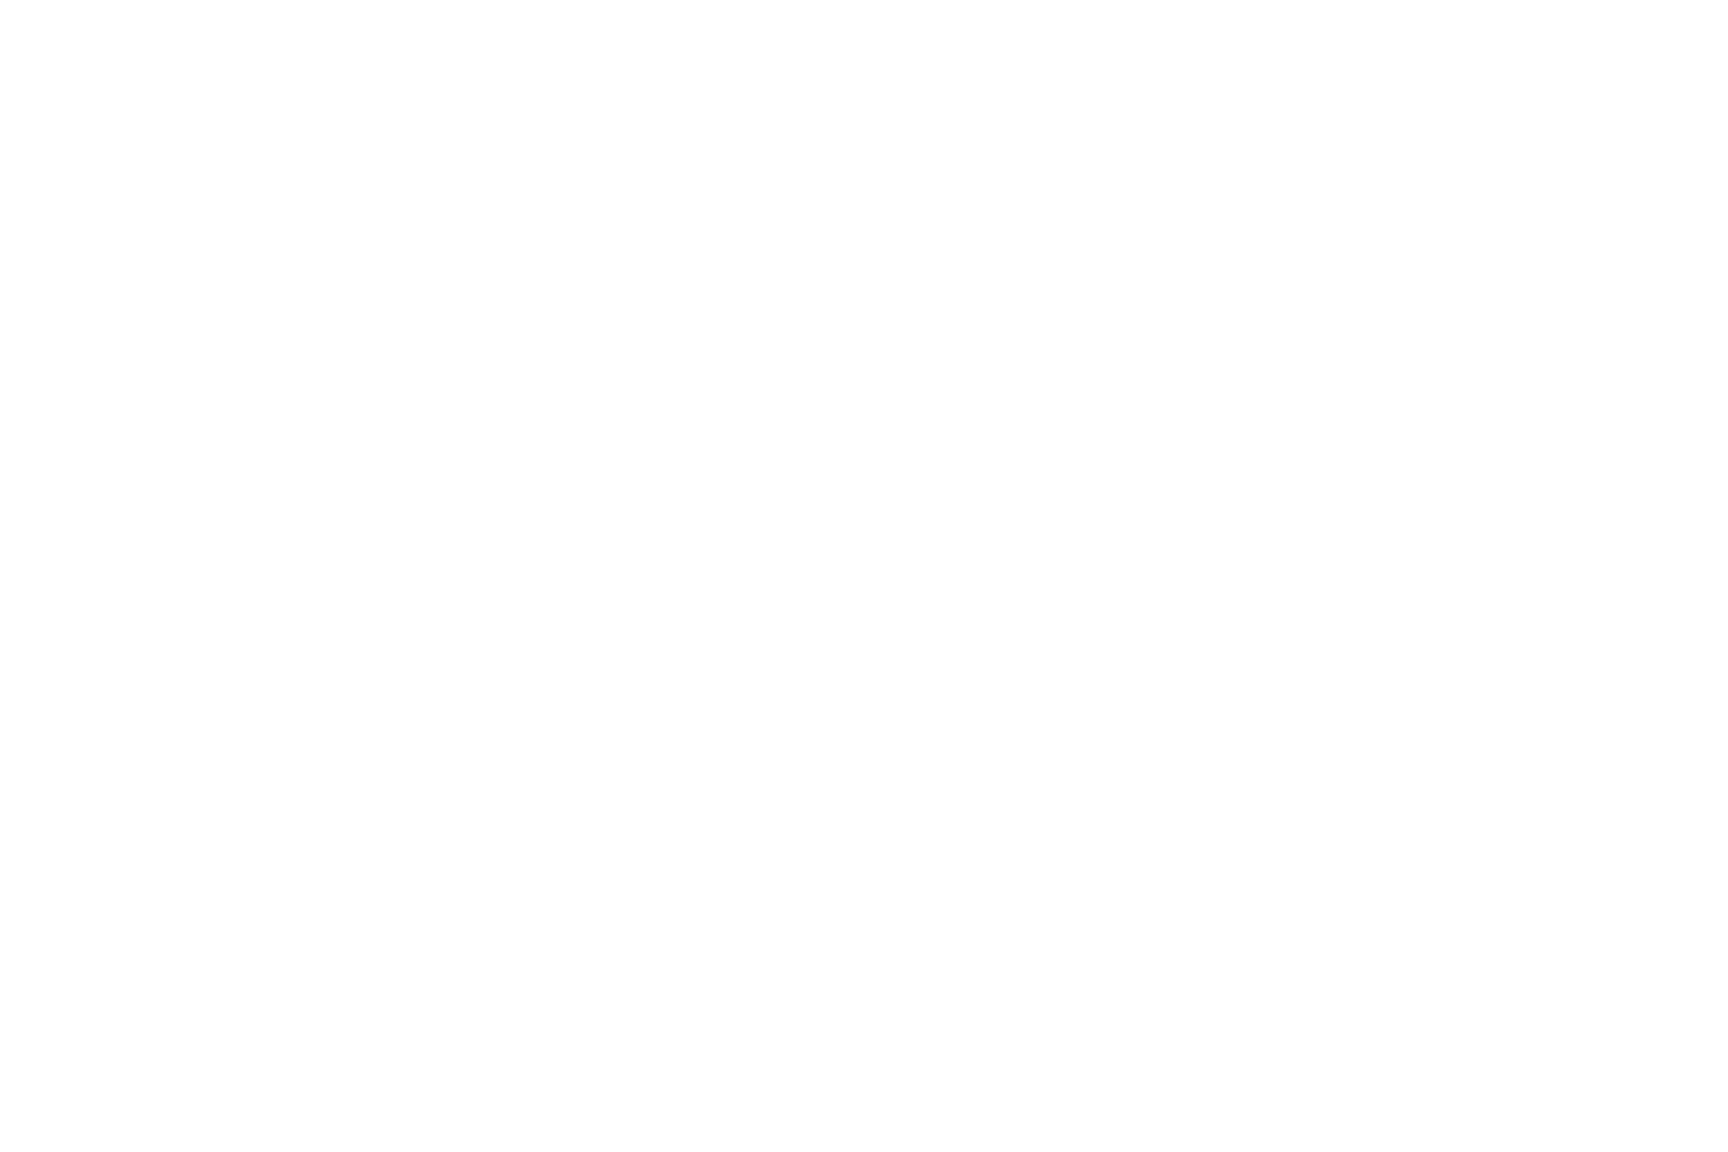

Epoch 1/60
527872/527872 [==============================] - 76s 143us/step - loss: 0.0838


/Users/johnblue/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/60
527872/527872 [==============================] - 74s 140us/step - loss: 0.0695
Epoch 3/60
527872/527872 [==============================] - 73s 138us/step - loss: 0.0663
Epoch 4/60
527872/527872 [==============================] - 76s 144us/step - loss: 0.0648
Epoch 5/60
527872/527872 [==============================] - 74s 139us/step - loss: 0.0643
Epoch 6/60
527872/527872 [==============================] - 73s 139us/step - loss: 0.0622
Epoch 7/60
527872/527872 [==============================] - 75s 142us/step - loss: 0.0610
Epoch 8/60
527872/527872 [==============================] - 72s 137us/step - loss: 0.0596
Epoch 9/60
527872/527872 [==============================] - 73s 138us/step - loss: 0.0583
Epoch 10/60
527872/527872 [==============================] - 73s 138us/step - loss: 0.0573
Epoch 11/60
527872/527872 [==============================] - 73s 138us/step - loss: 0.0564
Epoch 12/60
527872/527872 [==============================] - 72s 137us/step - loss: 0.0555
Epoch 1

<IPython.core.display.Javascript object>


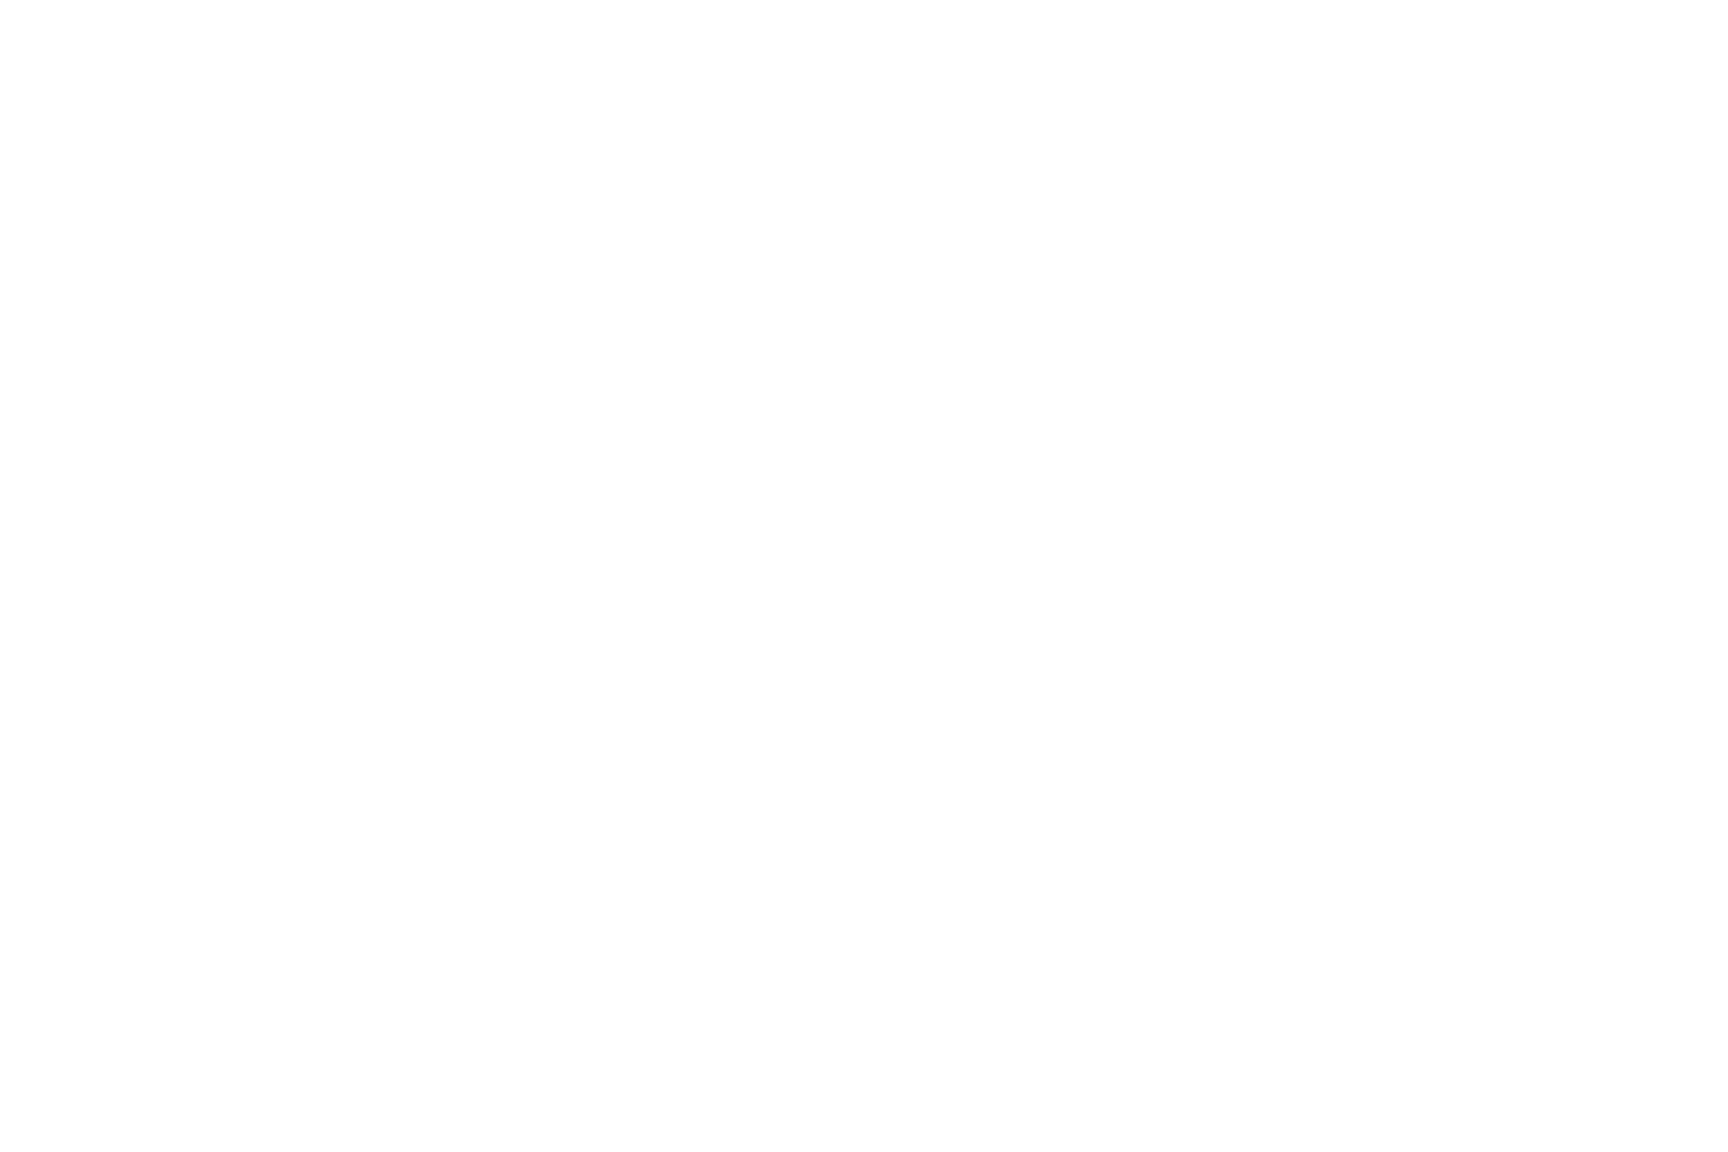

In [30]:
%%time
%matplotlib notebook

BATCH_SIZE = 512

best_params = {
#     'lr': 0.0005,
#     'lr': 0.01,
    'lr': 0.007,
#     'n_samples': BATCH_SIZE * 2 * 100,
#     'n_samples': 263000,
    'n_samples': math.floor(len(X_tr_s) / BATCH_SIZE) * BATCH_SIZE,
    'n_units': 16,
#     'n_units': 40,
    'batch_size': BATCH_SIZE,
#     'epochs': 100,
#     'epochs': 100,
    'epochs': 60,
    'optimizer': keras.optimizers.Adam,
}


# model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')
model = create_model(best_params)

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    X_te_s[:best_params['n_samples']],
    y_te_s[:best_params['n_samples']],
    best_params,
    verbose_fit=1,
    preview_n_start=14000,
    preview_n_end=(14000 + 2 * BATCH_SIZE),
)

globals().update(locals())

In [31]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-1.13408780e+00, -4.77888012e+00,  1.90717375e+00,
        -9.72389616e-03,  1.80979180e+00,  6.69821739e+00,
        -1.07302003e-01,  1.74023747e-01, -4.92250633e+00,
         3.92522454e-01,  6.73105270e-02, -2.52026629e+00,
         1.42066336e+00, -1.94784820e+00,  1.54009664e+00,
         1.92379320e+00,  4.77727026e-01, -3.64870727e-01,
         4.78508204e-01, -7.03614891e-01, -6.38219953e-01,
        -8.85796428e-01, -4.74812500e-02,  1.04786289e+00,
         1.45360458e+00,  8.82551849e-01,  2.45576784e-01,
        -1.59510148e+00,  3.24492604e-01, -4.69377100e-01,
         2.61575222e-01, -1.06864655e+00,  1.27793705e+00,
        -1.67634594e+00, -8.95084560e-01,  3.80433261e-01,
         7.10950232e+00, -3.71997929e+00,  1.11624393e+01,
         2.78826737e+00, -6.49274492e+00,  6.09811258e+00,
         1.87538373e+00,  7.64546454e-01, -5.71432784e-02,
         2.13375163e+00, -9.56280768e-01,  2.88941026e-01,
         2.05442786e-01, -1.76523626e+00,  1.3468799

In [1]:
model.summary()

NameError: name 'model' is not defined

# Save model

In [63]:
# https://stackoverflow.com/questions/58807467/tensorflow-keras-cudnngru-to-gru-conversion

def _convert_rnn_weights(layer, weights):
  """Converts weights for RNN layers between native and CuDNN format.

  Input kernels for each gate are transposed and converted between Fortran
  and C layout, recurrent kernels are transposed. For LSTM biases are summed/
  split in half, for GRU biases are reshaped.

  Weights can be converted in both directions between `LSTM` and`CuDNNSLTM`
  and between `CuDNNGRU` and `GRU(reset_after=True)`. Default `GRU` is not
  compatible with `CuDNNGRU`.

  For missing biases in `LSTM`/`GRU` (`use_bias=False`) no conversion is made.

  Arguments:
      layer: Target layer instance.
      weights: List of source weights values (input kernels, recurrent
          kernels, [biases]) (Numpy arrays).

  Returns:
      A list of converted weights values (Numpy arrays).

  Raises:
      ValueError: for incompatible GRU layer/weights or incompatible biases
  """


  def transform_kernels(kernels, func, n_gates):
    """Transforms kernel for each gate separately using given function.

    Arguments:
        kernels: Stacked array of kernels for individual gates.
        func: Function applied to kernel of each gate.
        n_gates: Number of gates (4 for LSTM, 3 for GRU).

    Returns:
        Stacked array of transformed kernels.
    """
    return np.hstack([func(k) for k in np.hsplit(kernels, n_gates)])


  def transpose_input(from_cudnn):
    """Makes a function that transforms input kernels from/to CuDNN format.

    It keeps the shape, but changes between the layout (Fortran/C). Eg.:

    ```
    Keras                 CuDNN
    [[0, 1, 2],  <--->  [[0, 2, 4],
     [3, 4, 5]]          [1, 3, 5]]
    ```

    It can be passed to `transform_kernels()`.

    Arguments:
        from_cudnn: `True` if source weights are in CuDNN format, `False`
            if they're in plain Keras format.

    Returns:
        Function that converts input kernel to the other format.
    """
    order = 'F' if from_cudnn else 'C'


    def transform(kernel):
      return kernel.T.reshape(kernel.shape, order=order)


    return transform


  target_class = layer.__class__.__name__


  # convert the weights between CuDNNLSTM and LSTM
  if target_class in ['LSTM', 'CuDNNLSTM'] and len(weights) == 3:
    # determine if we're loading a CuDNNLSTM layer
    # from the number of bias weights:
    # CuDNNLSTM has (units * 8) weights; while LSTM has (units * 4)
    # if there's no bias weight in the file, skip this conversion
    units = weights[1].shape[0]
    bias_shape = weights[2].shape
    n_gates = 4


    if bias_shape == (2 * units * n_gates,):
      source = 'CuDNNLSTM'
    elif bias_shape == (units * n_gates,):
      source = 'LSTM'
    else:
      raise ValueError('Invalid bias shape: ' + str(bias_shape))


    def convert_lstm_weights(weights, from_cudnn=True):
      """Converts the weights between CuDNNLSTM and LSTM.

      Arguments:
        weights: Original weights.
        from_cudnn: Indicates whether original weights are from CuDNN layer.

      Returns:
        Updated weights compatible with LSTM.
      """


      # Transpose (and reshape) input and recurrent kernels
      kernels = transform_kernels(weights[0], transpose_input(from_cudnn),
                                  n_gates)
      recurrent_kernels = transform_kernels(weights[1], lambda k: k.T, n_gates)
      if from_cudnn:
        # merge input and recurrent biases into a single set
        biases = np.sum(np.split(weights[2], 2, axis=0), axis=0)
      else:
        # Split single set of biases evenly to two sets. The way of
        # splitting doesn't matter as long as the two sets sum is kept.
        biases = np.tile(0.5 * weights[2], 2)
      return [kernels, recurrent_kernels, biases]


    if source != target_class:
      weights = convert_lstm_weights(weights, from_cudnn=source == 'CuDNNLSTM')


  # convert the weights between CuDNNGRU and GRU(reset_after=True)
  if target_class in ['GRU', 'CuDNNGRU'] and len(weights) == 3:
    # We can determine the source of the weights from the shape of the bias.
    # If there is no bias we skip the conversion since
    # CuDNNGRU always has biases.


    units = weights[1].shape[0]
    bias_shape = weights[2].shape
    n_gates = 3


    def convert_gru_weights(weights, from_cudnn=True):
      """Converts the weights between CuDNNGRU and GRU.

      Arguments:
        weights: Original weights.
        from_cudnn: Indicates whether original weights are from CuDNN layer.

      Returns:
        Updated weights compatible with GRU.
      """


      kernels = transform_kernels(weights[0], transpose_input(from_cudnn),
                                  n_gates)
      recurrent_kernels = transform_kernels(weights[1], lambda k: k.T, n_gates)
      biases = np.array(weights[2]).reshape((2, -1) if from_cudnn else -1)
      return [kernels, recurrent_kernels, biases]


    if bias_shape == (2 * units * n_gates,):
      source = 'CuDNNGRU'
    elif bias_shape == (2, units * n_gates):
      source = 'GRU(reset_after=True)'
    elif bias_shape == (units * n_gates,):
      source = 'GRU(reset_after=False)'
    else:
      raise ValueError('Invalid bias shape: ' + str(bias_shape))


    if target_class == 'CuDNNGRU':
      target = 'CuDNNGRU'
    elif layer.reset_after:
      target = 'GRU(reset_after=True)'
    else:
      target = 'GRU(reset_after=False)'


    # only convert between different types
    if source != target:
      types = (source, target)
      if 'GRU(reset_after=False)' in types:
        raise ValueError('%s is not compatible with %s' % types)
      if source == 'CuDNNGRU':
        weights = convert_gru_weights(weights, from_cudnn=True)
      elif source == 'GRU(reset_after=True)':
        weights = convert_gru_weights(weights, from_cudnn=False)


  return weights

In [173]:
# model_cpu = keras.models.clone_model(model)
model_cpu = create_model(best_params, recurrent_layer=LSTM)
model_cpu.build((None, best_params['batch_size'])) # replace 10 with number of variables in input layer
model_cpu.compile(optimizer=model.optimizer, loss=model.loss)
model_cpu

In [174]:
model.weights

[<tf.Variable 'cu_dnnlstm_1/kernel:0' shape=(3, 64) dtype=float32_ref>,
 <tf.Variable 'cu_dnnlstm_1/recurrent_kernel:0' shape=(16, 64) dtype=float32_ref>,
 <tf.Variable 'cu_dnnlstm_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'cu_dnnlstm_2/kernel:0' shape=(16, 64) dtype=float32_ref>,
 <tf.Variable 'cu_dnnlstm_2/recurrent_kernel:0' shape=(16, 64) dtype=float32_ref>,
 <tf.Variable 'cu_dnnlstm_2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(16, 1) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>]

In [194]:
# cudnn_gru and gru are built CuDNNGRU and GRU layers, respectively
target_layer = model_cpu.layers[1]
source_layer = model.layers[1]
source_layer_weights = source_layer.get_weights()

sess = K.tensorflow_backend.get_session()

kernel, recurrent_kernel, bias = _convert_rnn_weights(
    layer=target_layer,
    weights=[
        model.weights[0].eval(sess),  # kernel
        model.weights[1].eval(sess),  # recurrent_kernel
        model.weights[2].eval(sess),  # bias
#         source_layer_weights[0],  # kernel
#         source_layer_weights[1],  # recurrent_kernel
#         source_layer_weights[2],  # bias
    ],
)

target_layer.set_weights([kernel, recurrent_kernel, bias])
# target_layer.cell.kernel.assign(kernel)
# target_layer.cell.recurrent_kernel.assign(recurrent_kernel)
# target_layer.cell.bias.assign(bias)



target_layer = model_cpu.layers[2]
source_layer = model.layers[2]
source_layer_weights = source_layer.get_weights()
sess = K.tensorflow_backend.get_session()

kernel, recurrent_kernel, bias = _convert_rnn_weights(
    layer=target_layer,
    weights=[
        model.weights[3].eval(sess),  # kernel
        model.weights[4].eval(sess),  # recurrent_kernel
        model.weights[5].eval(sess),  # bias
#         source_layer_weights[0],  # kernel
#         source_layer_weights[1],  # recurrent_kernel
#         source_layer_weights[2],  # bias
    ],
)

target_layer.set_weights([kernel, recurrent_kernel, bias])
# target_layer.cell.kernel.assign(kernel)
# target_layer.cell.recurrent_kernel.assign(recurrent_kernel)
# target_layer.cell.bias.assign(bias)


target_layer = model_cpu.layers[3]
target_layer.set_weights(model.layers[3].get_weights())

In [164]:
np.array_equal(model_cpu.layers[2].get_weights(), model.layers[2].get_weights())

False

In [165]:
model_cpu

In [32]:
# store model

# model.save('saved_models/01_gru_6_units_01.h5')

MODEL_FILENAME = '10_lstm_1_layer_16_units'

with open('saved_models/{}.json'.format(MODEL_FILENAME), 'w') as fout:
    fout.write(model.to_json())
    
model.save_weights('saved_models/{}'.format(MODEL_FILENAME), overwrite=True)

In [34]:
# https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [35]:
from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 25 variables.
INFO:tensorflow:Converted 25 variables to const ops.


In [36]:
tf.train.write_graph(frozen_graph, "saved_models", "{}.pb".format(MODEL_FILENAME), as_text=False)


'saved_models/10_lstm_1_layer_16_units.pb'

In [37]:
# https://stackoverflow.com/a/43639305
    
sess = K.get_session()

tf.train.Saver(tf.trainable_variables()).save(sess, 'models/{}'.format(MODEL_FILENAME))

'models/10_lstm_1_layer_16_units'

In [65]:
print(model.input.op.name)

input_3


In [38]:

print(model.output.op.name)
sess = K.get_session()
saver = tf.train.Saver()
saver.save(sess, 'saved_models/10/model.ckpt')

dense_1/BiasAdd


'saved_models/10/model.ckpt'

In [39]:
score = model.evaluate(
    X_te_s[:(math.floor(len(X_te_s) / best_params['batch_size']) * best_params['batch_size'])],
    y_te_s[:(math.floor(len(y_te_s) / best_params['batch_size']) * best_params['batch_size'])],
    verbose=0,
    batch_size=best_params['batch_size'])

score

0.36268707065500766

In [46]:
0.17299184934683862

0.17299184934683862

In [43]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [96]:
len(X_te_s)

199870

In [76]:
# n = 2 * 44000
n = X_tr_s.shape[0]

pred = predict(
    model,
    X_tr_s[:(math.floor(n / best_params['batch_size']) * best_params['batch_size'])],
    batch_size=best_params['batch_size']
)

ipd.Audio(pred, rate=44000)

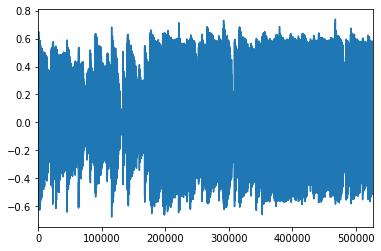

In [72]:
%matplotlib inline
pd.Series(pred).plot.line()

In [70]:
print(X_tr_s[0][-1])

[9.155553e-05 0.000000e+00]


In [278]:
from keras import backend as K

def divide_chunks(l, n): 
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
        
def get_activations_batch(model, n_layer, X_batch):
    get_activations = K.function([model.layers[0].input], [model.layers[n_layer].output])
    activations = get_activations([X_batch, 0])[0]
    return activations

def get_activations(model, n_layer, X, batch_size):
    chunks = divide_chunks(X, batch_size)
    return np.concatenate([get_activations_batch(model, n_layer, X_batch) for X_batch in chunks])

In [79]:
get_activations(model, 1, X_tr_s[:2000], best_params['batch_size'])[:3]

array([[ 1.        ,  0.7350165 ,  0.99999666,  0.993649  , -0.99999994,
         0.23880738,  0.953165  ,  0.15217732,  0.99743134,  1.        ,
         0.99999785, -0.03889839, -0.99999785,  0.82558966, -0.99716634,
        -0.68713343, -0.23584732,  0.4237997 , -0.9999999 , -0.999841  ,
        -0.9576221 , -0.10611475, -0.13686267, -0.99912405],
       [ 1.        ,  0.735579  ,  0.9999966 ,  0.99366   , -0.99999994,
         0.23837912,  0.95343316,  0.15351263,  0.99743134,  1.        ,
         0.99999785, -0.03890467, -0.99999785,  0.82557327, -0.9971662 ,
        -0.68684864, -0.23518775,  0.41855776, -0.9999999 , -0.99984413,
        -0.9576741 , -0.10585959, -0.13685378, -0.99912405],
       [ 1.        ,  0.73611784,  0.99999654,  0.9936677 , -0.99999994,
         0.23788646,  0.953497  ,  0.15426376,  0.9974319 ,  1.        ,
         0.99999785, -0.03897721, -0.99999785,  0.8258032 , -0.99716586,
        -0.68680143, -0.23472807,  0.41283783, -0.9999999 , -0.9998479 ,
  

Text(0, 0.5, 'value')

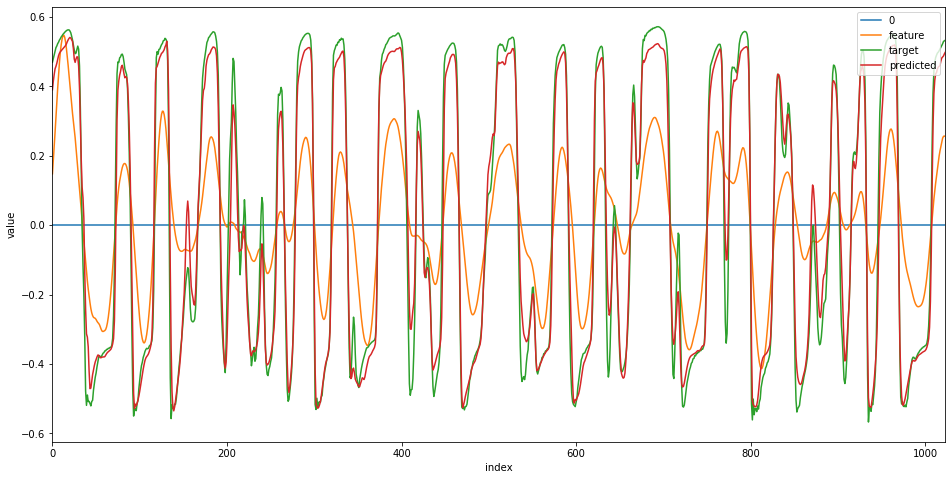

In [78]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 1024
MAGIC_OFFSET = 180000
OFFSET = int(MAGIC_OFFSET)

X_to_test = X_tr_s
y_to_test = y_tr_s

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

feat = pd.Series(np.array(list(map(lambda row: row[-1][0], X_to_test[OFFSET:(I + OFFSET)]))))

feat.plot.line(ax=ax, label='feature')

targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])

pred = pd.Series(predict(model, X_to_test[OFFSET:(I + OFFSET)], batch_size=best_params['batch_size']))
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

# act = pd.Series([ row[1] for row in get_activations( model, 1, X_to_test[OFFSET:(I + OFFSET)], best_params['batch_size'])] )

# IMPORTANT_GRUS = []

# act.plot.line(ax=ax, label='GRU layer activation')

targ.plot.line(ax=ax, label='target')

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_te_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

In [1]:
weights = model.layers[1].get_weights()
(W, U, b) = weights
W.shape, U.shape, b.shape

NameError: name 'model' is not defined

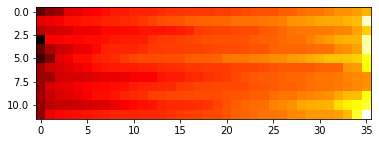

In [288]:
plt.imshow(np.sort(U, axis=1), cmap='hot', interpolation='nearest')

In [289]:
U_c = np.array([])

# we have 3 features

units = best_params['n_units']

W_0_h = W[0, :units]
W_0_r = W[0, units: units * 2]
W_0_z = W[0, units * 2: units * 3]

W_1_h = W[1, :units]
W_1_r = W[1, units: units * 2]
W_1_z = W[1, units * 2: units * 3]

W_2_h = W[2, :units]
W_2_r = W[2, units: units * 2]
W_2_z = W[2, units * 2: units * 3]

U_h = U[:, :units]
U_r = U[:, units: units * 2]
U_z = U[:, units * 2: units * 3]

b_1 = b[:units]
b_2 = b[units: units * 2]
b_3 = b[units * 2: units * 3]
b_4 = b[units * 3: units * 4]
b_5 = b[units * 4: units * 5]
b_6 = b[units * 5:]

U_h.shape

(12, 12)

In [290]:
pred_unit = pd.Series([ row[1] for row in get_activations( model, 1, X_tr_s[:230000], best_params['batch_size'])] )
pred_unit[:10]

KeyboardInterrupt: 

In [245]:
ipd.Audio(pred_unit, rate=44000)

In [195]:
N = 5

W_su = np.array([
    np.array([ W_0_h[N], W_0_r[N], W_0_z[N] ]),
    np.array([ W_1_h[N], W_1_r[N], W_1_z[N] ]),
    np.array([ W_2_h[N], W_2_r[N], W_2_z[N] ])
])

U_su = np.array([
    np.array([
        U_h[N],
        U_r[N],
        U_z[N],
    ])
])

W_su, U_su

(array([[-0.0022899893,  0.43562603  ,  0.028196046 ],
        [-0.4824497   , -0.05763771  ,  0.2697497   ],
        [ 0.04989334  ,  0.3810869   ,  0.039342176 ]], dtype=float32),
 array([[[-3.28866951e-02, -1.02324295e+00,  1.74627975e-01,
          -1.16138242e-01,  1.10327318e-01,  8.43107641e-01,
          -9.35797155e-01,  3.73737454e-01,  1.41992664e-03,
           1.65796295e-01,  7.76039004e-01,  6.43501699e-01,
          -5.35436384e-02, -4.69782352e-01,  6.31801635e-02,
           1.45995095e-01,  3.51827174e-01, -1.45192659e+00,
          -1.70130923e-01,  2.93677241e-01, -9.04179037e-01,
           5.07917464e-01, -4.41755801e-01,  1.66603476e-02],
         [ 1.28369465e-01,  1.61231029e+00,  1.47629336e-01,
          -2.88780802e-03,  6.84055267e-03, -2.18628216e+00,
           2.54989767e+00, -5.75977683e-01,  1.77933022e-01,
          -5.33041321e-02,  3.97446975e-02,  8.55978489e-01,
          -2.17247561e-01,  3.27902317e-01, -8.43632035e-03,
           1.04471199e-0

In [172]:
layer = model.layers[1]

In [170]:
W_1.shape

(24, 24)

In [57]:
matplotlib inline

def plot_params(l, m):
    (fig, ax) = plt.subplots(figsize=(16, 8))

    I = 1000
    MAGIC_OFFSET = 180000
    OFFSET = int(MAGIC_OFFSET)

    X_source = np.array(list(map(lambda x: [x, l, m], source_df[OFFSET:(I + OFFSET + N_WINDOW_POINTS + 1)] / MAX_VALUE)))
    (X, _) = make_windows(X_source, [0] * (I + N_WINDOW_POINTS + 1), N_WINDOW_POINTS)
    X_to_test = X
    

    feat = source_df[OFFSET:(I + OFFSET)].reset_index()['L'] / MAX_VALUE
    
    feat.plot.line(ax=ax, label='feature')

#     targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])
    
    pred = pd.Series(predict(model, X_to_test, batch_size=best_params['batch_size']))
    # pred = (pred * 3.2) + 0.001
    pred = pred + 0.001
    
    zeros = pd.Series(np.zeros(I))
    zeros.plot.line(ax=ax, label='0')

#     targ.plot.line(ax=ax, label='target')

    pred.plot.line(ax=ax, label='predicted')
    
    ax.legend(loc="upper right")
    ax.set_xlabel('index')
    ax.set_ylabel('value')

In [156]:
from ipywidgets import interact

interact(plot_params, l=(0, 10), m=(0, 10))

interactive(children=(IntSlider(value=5, description='l', max=10), IntSlider(value=5, description='m', max=10)…

<function __main__.plot_params(l, m)>


## Time to evaluate performance

In [99]:
from math import floor

train_pred = predict(model, X_tr_s[:floor(len(X_tr_s) / (best_params['batch_size'] * 2)) * best_params['batch_size']], batch_size=best_params['batch_size'])
ipd.Audio(train_pred, rate=44000)

MemoryError: 

In [114]:
# X_to_repeat = X_tr_s[:int(44000 * 2.8)]
# X_to_pred = np.concatenate([X_to_repeat, X_to_repeat, X_to_repeat])
# len(X_to_pred) / 44000, X_to_pred[0][:4], X_to_pred[1][:4]

In [61]:
def mapper(a):
    i = a[0]
    row = a[1]
    
    t = i / len(X_to_pred)
    gain = 1.0 * (1 - t) + 6.4 * t
    
    return np.array(list(map(lambda x: [x[0], gain], row)))

# X_to_pred = np.array(list(map(mapper, enumerate(X_to_pred))))

# X_to_pred[0][:5], X_to_pred[1][:5], X_to_pred[-2][:5], X_to_pred[-1][:5]

In [67]:
X_to_pred = X_tr_s[:(X_tr_s.shape[0] // best_params['batch_size']) * best_params['batch_size']]

In [68]:
predictions = predict(model, X_to_pred, batch_size=best_params['batch_size'], verbose=1)
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

263000/263000 [==============================] - 1s 3us/step


(263000,
 array([-0.05937488, -0.0590545 , -0.05882681, -0.05877836, -0.05880947,
        -0.05874747, -0.05854729, -0.05837908, -0.0582295 , -0.05822694],
       dtype=float32),
 1.0069656,
 -1.3094412)

In [69]:
np.min(y_te_s)

-0.74059266

In [70]:
predictions_n = np.clip((predictions / 1.2) * 0.8, -1.0, 1.0) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

(263000, array([-1297.0243, -1290.0258, -1285.052 , -1283.9937, -1284.6731,
        -1283.3188, -1278.9459, -1275.2715, -1272.004 , -1271.948 ],
       dtype=float32), 21996.826, -28604.305)

In [71]:
wavfile.write('output/pred_out_gr_jump_head_gain_2_params_v3.wav', source_fs, predictions)

In [128]:
len(predictions) / 44000

1.9772727272727273

In [291]:
n_desired = X_te_s.shape[0]
n = math.floor(n_desired / best_params['batch_size']) * best_params['batch_size']

pred_ordinary = predict(
    model,
    X_te_s[:n],
    batch_size=best_params['batch_size']
)

In [292]:
pred_ordinary.shape, pred_ordinary[0], pred_ordinary[-1]

((7680,), 0.64113635, -0.29599294)

In [293]:
X_te_s.shape

(7870, 64, 3)

In [294]:
pred_testing = predict(
    model,
    np.array(list([X_te_s[n - 1]] * best_params['batch_size'])),
    batch_size=best_params['batch_size']
)

In [295]:
pd.Series(pred_testing).describe()

count    256.000000
mean      -0.295993
std        0.000000
min       -0.295993
25%       -0.295993
50%       -0.295993
75%       -0.295993
max       -0.295993
dtype: float64

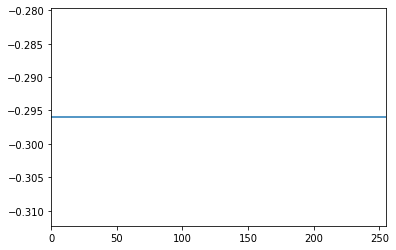

In [296]:
pd.Series(pred_testing).plot.line()

In [297]:
# check if permutation changes predictions

In [298]:
perm = np.random.permutation(n)
perm

array([1571, 1900, 2958, ..., 6445, 6713, 1988])

In [299]:
pred_perm = predict(
    model,
    X_te_s[perm],
    batch_size=best_params['batch_size']
)

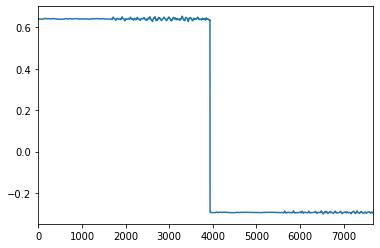

In [300]:
pd.Series(pred_perm[np.argsort(perm)]).plot.line()

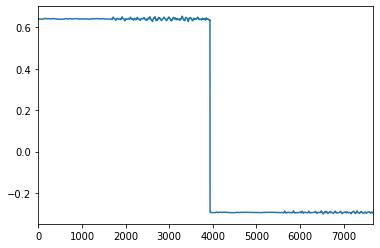

In [301]:
pd.Series(pred_ordinary).plot.line()

In [304]:
# order does not matter when stateful=False